In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc
import optuna
import logging

In [2]:
data = pd.read_csv('HAM10000_metadata.csv')
path = os.path.join("segmented_images")
list1 = []
for i in os.scandir(path):
    list1.append(i.path)

dict1 = {"image_path":list1}
for i in data.columns.values:
    dict1[i] = list(data[i])

In [3]:
oneHot = OneHotEncoder()
l = []
res = oneHot.fit_transform(data["dx"].to_frame()).toarray()
for i in res:
    l.append(i.argmax())

dict1["dx_cat"] = l
data = pd.concat([pd.Series(v,name=k) for k,v in dict1.items()],axis=1)

In [4]:
data

,image_path,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_cat
0,segmented_images/ISIC_0024306.jpg,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,segmented_images/ISIC_0024307.jpg,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,segmented_images/ISIC_0024308.jpg,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,segmented_images/ISIC_0024309.jpg,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,segmented_images/ISIC_0024310.jpg,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
...,...,...,...,...,...,...,...,...,...
10010,segmented_images/ISIC_0034316.jpg,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0
10011,segmented_images/ISIC_0034317.jpg,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0
10012,segmented_images/ISIC_0034318.jpg,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0
10013,segmented_images/ISIC_0034319.jpg,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0


# Preprocessing

**Normalize function**

In [5]:
img_h, img_w = 224, 224

In [6]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

In [7]:
norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

**Data Augmentation and normalization**

**Resize the data as 244X244 because most pretrainned models are that size**

In [8]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [9]:
data.head()

,image_path,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_cat
0,segmented_images/ISIC_0024306.jpg,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,segmented_images/ISIC_0024307.jpg,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,segmented_images/ISIC_0024308.jpg,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,segmented_images/ISIC_0024309.jpg,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,segmented_images/ISIC_0024310.jpg,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


**Data Loading**

In [10]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [11]:
batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 4006 Val: 4006 Test: 2003


**Batch check**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.095985..2.7474492].


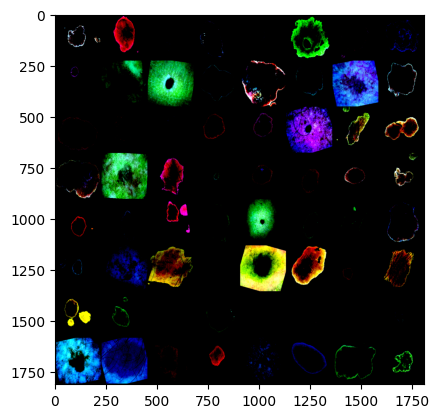

Labels:  tensor([5, 4, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 6, 5, 5, 5, 5, 4, 5, 6, 5, 5, 5, 5,
        4, 1, 5, 2, 5, 6, 1, 5, 3, 5, 5, 5, 5, 5, 5, 1, 2, 4, 2, 5, 5, 4, 5, 5,
        5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5])


In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels) 

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


## Hyperparameter tunning

Balanced subsample split

In [15]:
selected_data = data.groupby('dx').apply(lambda x: x.sample(n=110)).reset_index(drop=True)
selected_data.head()

/tmp/ipykernel_16904/1200833159.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_data = data.groupby('dx').apply(lambda x: x.sample(n=110)).reset_index(drop=True)


,image_path,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_cat
0,segmented_images/ISIC_0034242.jpg,HAM_0006887,ISIC_0029500,akiec,histo,45.0,male,face,0
1,segmented_images/ISIC_0034105.jpg,HAM_0000456,ISIC_0026466,akiec,histo,65.0,female,upper extremity,0
2,segmented_images/ISIC_0034118.jpg,HAM_0005264,ISIC_0029371,akiec,histo,45.0,male,back,0
3,segmented_images/ISIC_0034093.jpg,HAM_0002261,ISIC_0025808,akiec,histo,50.0,male,back,0
4,segmented_images/ISIC_0034068.jpg,HAM_0006560,ISIC_0026729,akiec,histo,50.0,male,face,0


In [16]:
class CNNet_trial(nn.Module):
    def __init__(self, num_filters, num_classes, num_of_layers):
        super(CNNet_trial, self).__init__()
        
        self.layers = nn.ModuleList()
        in_channels = 3         
        for out_channels in num_filters:
            self.layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ))
            in_channels = out_channels
        
        self.flat_features = int(num_filters[-1] * (224/2**num_of_layers) * (224/2**num_of_layers))
        self.fc1 = nn.Linear(self.flat_features, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
train_val_trial, test_trial = train_test_split(selected_data, test_size=0.2, random_state=42)

train_trial, val_trial = train_test_split(selected_data, test_size=0.5, random_state=42)

train_trial = HAM10000Dataset(train_trial, transform=transform)
val_trial = HAM10000Dataset(val_trial, transform=transform)
test_trial = HAM10000Dataset(test_trial, transform=transform)

batch_size = 64
num_workers = 5

train_loader_trial = DataLoader(train_trial, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_trial = DataLoader(val_trial, batch_size=batch_size, num_workers=num_workers)
test_loader_trial = DataLoader(test_trial, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_trial), 'Val:', len(val_trial), 'Test:', len(test_trial))

Data len Train: 385 Val: 385 Test: 154


/home/anirudhata/Desktop/DNN_Ham10000/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Set the optuna parameters**

In [18]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    num_of_layers = trial.suggest_int('num_of_layers', 3, 4)
    if num_of_layers == 4:
        num_filters = trial.suggest_categorical('num_filters_4_layers', [[16, 32, 64, 128], [32, 64, 128, 256], [64, 128, 256, 512], [16, 32, 128, 512],
                                                                          [32, 32, 64, 256], [32, 128, 256, 256], [32, 128, 128, 256], [128, 256, 512, 512]])
    else:
        num_filters = trial.suggest_categorical('num_filters_3_layers', [[16, 64, 128], [32, 128, 256], [64, 128, 256], [128, 256, 512], [16, 32, 64],
                                                                         [16, 32, 128], [32, 128, 128], [64, 256, 256], [32, 256, 512], [16, 128, 512]])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD','AdamW'])        
    epochs = 30
    patience =5  
    model = CNNet_trial(num_filters=num_filters, num_classes=7, num_of_layers=num_of_layers)
    model = model.to(device)
    input_size = (3, 224, 224)
    criterion = nn.CrossEntropyLoss().to(device)

    optimizer = {
        'Adam': optim.Adam(model.parameters(), lr=learning_rate),
        'RMSprop': optim.RMSprop(model.parameters(), lr=learning_rate),
        'SGD': optim.SGD(model.parameters(), lr=learning_rate),
        'AdamW': optim.AdamW(model.parameters(), lr=learning_rate)
    }[optimizer_name]
        
    model_filename = 'CNN_model_{trial}.pth'

    try:
        _, _, _, _, total_acc_val = Model_functions.train_and_validate_model(
            model, train_loader_trial, val_loader_trial, test_loader_trial, criterion, patience, optimizer, device, epochs,model_filename)

        return max(total_acc_val)  
    finally:
        del model, optimizer
        torch.cuda.empty_cache()
        gc.collect()


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10,show_progress_bar=True) 

print("Best trial:")
trial = study.best_trial
print(f" Validation Accuracy: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

| Hyperparameter          | Value                           |
|-------------------------|---------------------------------|
| num_of_layers           | 4                               |
| num_filters_4_layers    | [64, 128, 256, 512]             |
| learning_rate           | 0.001                           |
| optimizer               | Adam                            |
| epochs                  | 29                              |
| **Best Trial Value**    | 77.82              |


# Make the custom model

**Initiate the model with the best hyperparameters**

In [11]:
num_classes = 7

In [12]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(64),            
        nn.ReLU(),            
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))

        self.fc1 = nn.Linear(512 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = x.view(-1, 3, img_h, img_w)
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)

        out = out4.view(out4.size(0), -1) #makes them flat
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

CNN_model = CNNet()

In [14]:
CNN_model = CNN_model.to(device)
input_size = (3, 224, 224)
print(summary(CNN_model, input_size, device=device.type))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 112, 112]        --
├─Sequential: 1-2                        [-1, 128, 56, 56]         --
|    └─Conv2d: 2-5                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-6                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-8                    [-1, 128, 56, 56]         --
├─Sequential: 1-3                        [-1, 256, 28, 28]         --
|    └─Conv2d: 2-9                       [-1, 256, 56, 56]         295,168
|    └─BatchNorm2d: 2-10                 [-1, 256, 56, 56]         512


In [15]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-3)

**Fit the model using Validation set for the best model selection**

In [16]:
epochs = 30
patience = 5
model_filename = 'CNN_model.pth'
model = CNN_model
start_time = time.time()
CNN_model_fitted, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename, verbose=True)
end_time = time.time()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1
Training Loss: 2.2001195119828294 
Training Accuracy: 40.40608315806504%
Validation Loss: 1.3620735640378343 
Validation Accuracy: 46.740009707167125%
Validation Loss Decreased(inf--->1.362074) 
Saving The Model


  3%|▎         | 1/30 [01:26<41:43, 86.32s/it]

Epoch 2
Training Loss: 1.1807535373672997 
Training Accuracy: 56.697945316291865%
Validation Loss: 1.1500421885362606 
Validation Accuracy: 58.21064552661382%
Validation Loss Decreased(1.362074--->1.150042) 
Saving The Model


  7%|▋         | 2/30 [02:52<40:08, 86.03s/it]

Epoch 3
Training Loss: 1.019773160981149 
Training Accuracy: 62.659763792266624%
Validation Loss: 0.945107168450798 
Validation Accuracy: 64.94094806665588%
Validation Loss Decreased(1.150042--->0.945107) 
Saving The Model


 10%|█         | 3/30 [04:19<39:03, 86.78s/it]

Epoch 4
Training Loss: 0.8464675306044903 
Training Accuracy: 68.93706519980586%
Validation Loss: 0.8475139583508993 
Validation Accuracy: 68.72674324542955%
Validation Loss Decreased(0.945107--->0.847514) 
Saving The Model


 13%|█▎        | 4/30 [05:48<37:59, 87.66s/it]

Epoch 5
Training Loss: 0.7666322244811303 
Training Accuracy: 71.65507199482285%
Validation Loss: 0.7830969938605102 
Validation Accuracy: 70.08574664293803%
Validation Loss Decreased(0.847514--->0.783097) 
Saving The Model


 17%|█▋        | 5/30 [07:16<36:27, 87.52s/it]

Epoch 6
Training Loss: 0.687607934026374 
Training Accuracy: 74.48632907296555%
Validation Loss: 0.6468462194364095 
Validation Accuracy: 76.32260152078952%
Validation Loss Decreased(0.783097--->0.646846) 
Saving The Model


 20%|██        | 6/30 [08:44<35:06, 87.76s/it]

Epoch 7
Training Loss: 0.6308061617244151 
Training Accuracy: 76.69470959391684%
Validation Loss: 0.6099638928150394 
Validation Accuracy: 77.64115838861025%
Validation Loss Decreased(0.646846--->0.609964) 
Saving The Model


 27%|██▋       | 8/30 [11:39<32:06, 87.56s/it]

Epoch 8
Training Loss: 0.5738298891438651 
Training Accuracy: 79.09723345736936%
Validation Loss: 0.6268782641777059 
Validation Accuracy: 77.56026532923475%
Epoch 9
Training Loss: 0.5323097403209234 
Training Accuracy: 80.52904060831581%
Validation Loss: 0.521287022100896 
Validation Accuracy: 81.37841773175862%
Validation Loss Decreased(0.609964--->0.521287) 
Saving The Model


 30%|███       | 9/30 [13:06<30:38, 87.53s/it]

Epoch 10
Training Loss: 0.4988825656089586 
Training Accuracy: 81.81524025238635%
Validation Loss: 0.48405148342405396 
Validation Accuracy: 82.63226015207896%
Validation Loss Decreased(0.521287--->0.484051) 
Saving The Model


 37%|███▋      | 11/30 [16:00<27:39, 87.34s/it]

Epoch 11
Training Loss: 0.4574142052724804 
Training Accuracy: 82.99627891926873%
Validation Loss: 0.5730106219188454 
Validation Accuracy: 79.7120207086232%
Epoch 12
Training Loss: 0.4210114686836287 
Training Accuracy: 84.64649733052904%
Validation Loss: 0.38362915691026706 
Validation Accuracy: 86.05403656366283%
Validation Loss Decreased(0.484051--->0.383629) 
Saving The Model


 43%|████▎     | 13/30 [18:55<24:43, 87.29s/it]

Epoch 13
Training Loss: 0.4029646982467666 
Training Accuracy: 85.43924931240899%
Validation Loss: 0.43297477465929446 
Validation Accuracy: 84.07215660896296%
Epoch 14
Training Loss: 0.37369267235404435 
Training Accuracy: 86.43423394272772%
Validation Loss: 0.33779833181617186 
Validation Accuracy: 88.06827374211292%
Validation Loss Decreased(0.383629--->0.337798) 
Saving The Model


 50%|█████     | 15/30 [21:50<21:51, 87.43s/it]

Epoch 15
Training Loss: 0.3448039764135154 
Training Accuracy: 88.01164860055007%
Validation Loss: 0.34823374434844734 
Validation Accuracy: 87.99546998867497%
Epoch 16
Training Loss: 0.32007318136003826 
Training Accuracy: 88.56981071024106%
Validation Loss: 0.2900970527883043 
Validation Accuracy: 89.81556382462385%
Validation Loss Decreased(0.337798--->0.290097) 
Saving The Model


 57%|█████▋    | 17/30 [24:44<18:52, 87.10s/it]

Epoch 17
Training Loss: 0.30364723008164424 
Training Accuracy: 89.14415143180715%
Validation Loss: 0.4705146291514033 
Validation Accuracy: 83.46545866364666%
Epoch 18
Training Loss: 0.3115268199099708 
Training Accuracy: 89.14415143180715%
Validation Loss: 0.26848000345617223 
Validation Accuracy: 90.42226176994014%
Validation Loss Decreased(0.290097--->0.268480) 
Saving The Model


 60%|██████    | 18/30 [26:12<17:27, 87.28s/it]

Epoch 19
Training Loss: 0.2722754537982425 
Training Accuracy: 90.33327940462708%
Validation Loss: 0.23304861265513085 
Validation Accuracy: 91.71655071994823%
Validation Loss Decreased(0.268480--->0.233049) 
Saving The Model


 63%|██████▎   | 19/30 [27:38<15:55, 86.89s/it]

Epoch 20
Training Loss: 0.26267818119568925 
Training Accuracy: 90.92379873806827%
Validation Loss: 0.21964872459468154 
Validation Accuracy: 92.32324866526452%
Validation Loss Decreased(0.233049--->0.219649) 
Saving The Model


 70%|███████   | 21/30 [30:28<12:53, 85.89s/it]

Epoch 21
Training Loss: 0.27322606811511146 
Training Accuracy: 90.72965539556706%
Validation Loss: 0.30161156923961396 
Validation Accuracy: 89.36256269212102%


 73%|███████▎  | 22/30 [31:52<11:24, 85.52s/it]

Epoch 22
Training Loss: 0.2174979513415049 
Training Accuracy: 92.19381977026372%
Validation Loss: 0.23504702643174485 
Validation Accuracy: 91.74890794369843%


 77%|███████▋  | 23/30 [33:17<09:57, 85.29s/it]

Epoch 23
Training Loss: 0.22759818527655504 
Training Accuracy: 91.95922989807474%
Validation Loss: 0.24204216885966123 
Validation Accuracy: 92.00776573370005%


 80%|████████  | 24/30 [34:42<08:31, 85.19s/it]

Epoch 24
Training Loss: 0.2002031851137422 
Training Accuracy: 93.14835787089467%
Validation Loss: 0.30527179826473455 
Validation Accuracy: 90.50315482931565%
Epoch 25
Training Loss: 0.20650229055780112 
Training Accuracy: 92.7358032680796%
Validation Loss: 0.2059940499512805 
Validation Accuracy: 93.38294774308365%
Validation Loss Decreased(0.219649--->0.205994) 
Saving The Model


 87%|████████▋ | 26/30 [37:32<05:40, 85.11s/it]

Epoch 26
Training Loss: 0.22575426696962916 
Training Accuracy: 92.17764115838861%
Validation Loss: 0.24466797023934803 
Validation Accuracy: 91.67610419026047%
Epoch 27
Training Loss: 0.190946804897226 
Training Accuracy: 93.23734023620773%
Validation Loss: 0.1871420474166108 
Validation Accuracy: 93.63371622714772%
Validation Loss Decreased(0.205994--->0.187142) 
Saving The Model


 93%|█████████▎| 28/30 [40:22<02:49, 84.93s/it]

Epoch 28
Training Loss: 0.17300568684244277 
Training Accuracy: 93.85212748746157%
Validation Loss: 0.23558033073378593 
Validation Accuracy: 91.84597961494904%
Epoch 29
Training Loss: 0.16849544083641976 
Training Accuracy: 94.2889500080893%
Validation Loss: 0.1716357545600724 
Validation Accuracy: 94.54780779809093%
Validation Loss Decreased(0.187142--->0.171636) 
Saving The Model


 97%|█████████▋| 29/30 [41:47<01:25, 85.00s/it]

Epoch 30
Training Loss: 0.1679617316298878 
Training Accuracy: 94.19996764277624%
Validation Loss: 0.13956617293447332 
Validation Accuracy: 95.68839993528555%
Validation Loss Decreased(0.171636--->0.139566) 
Saving The Model


100%|██████████| 30/30 [43:12<00:00, 86.41s/it]


In [17]:
total_time = end_time - start_time
print(f"Total training and validation time for our Model: {total_time/60:.2f} minutes")

Total training and validation time for our Model: 43.21 minutes


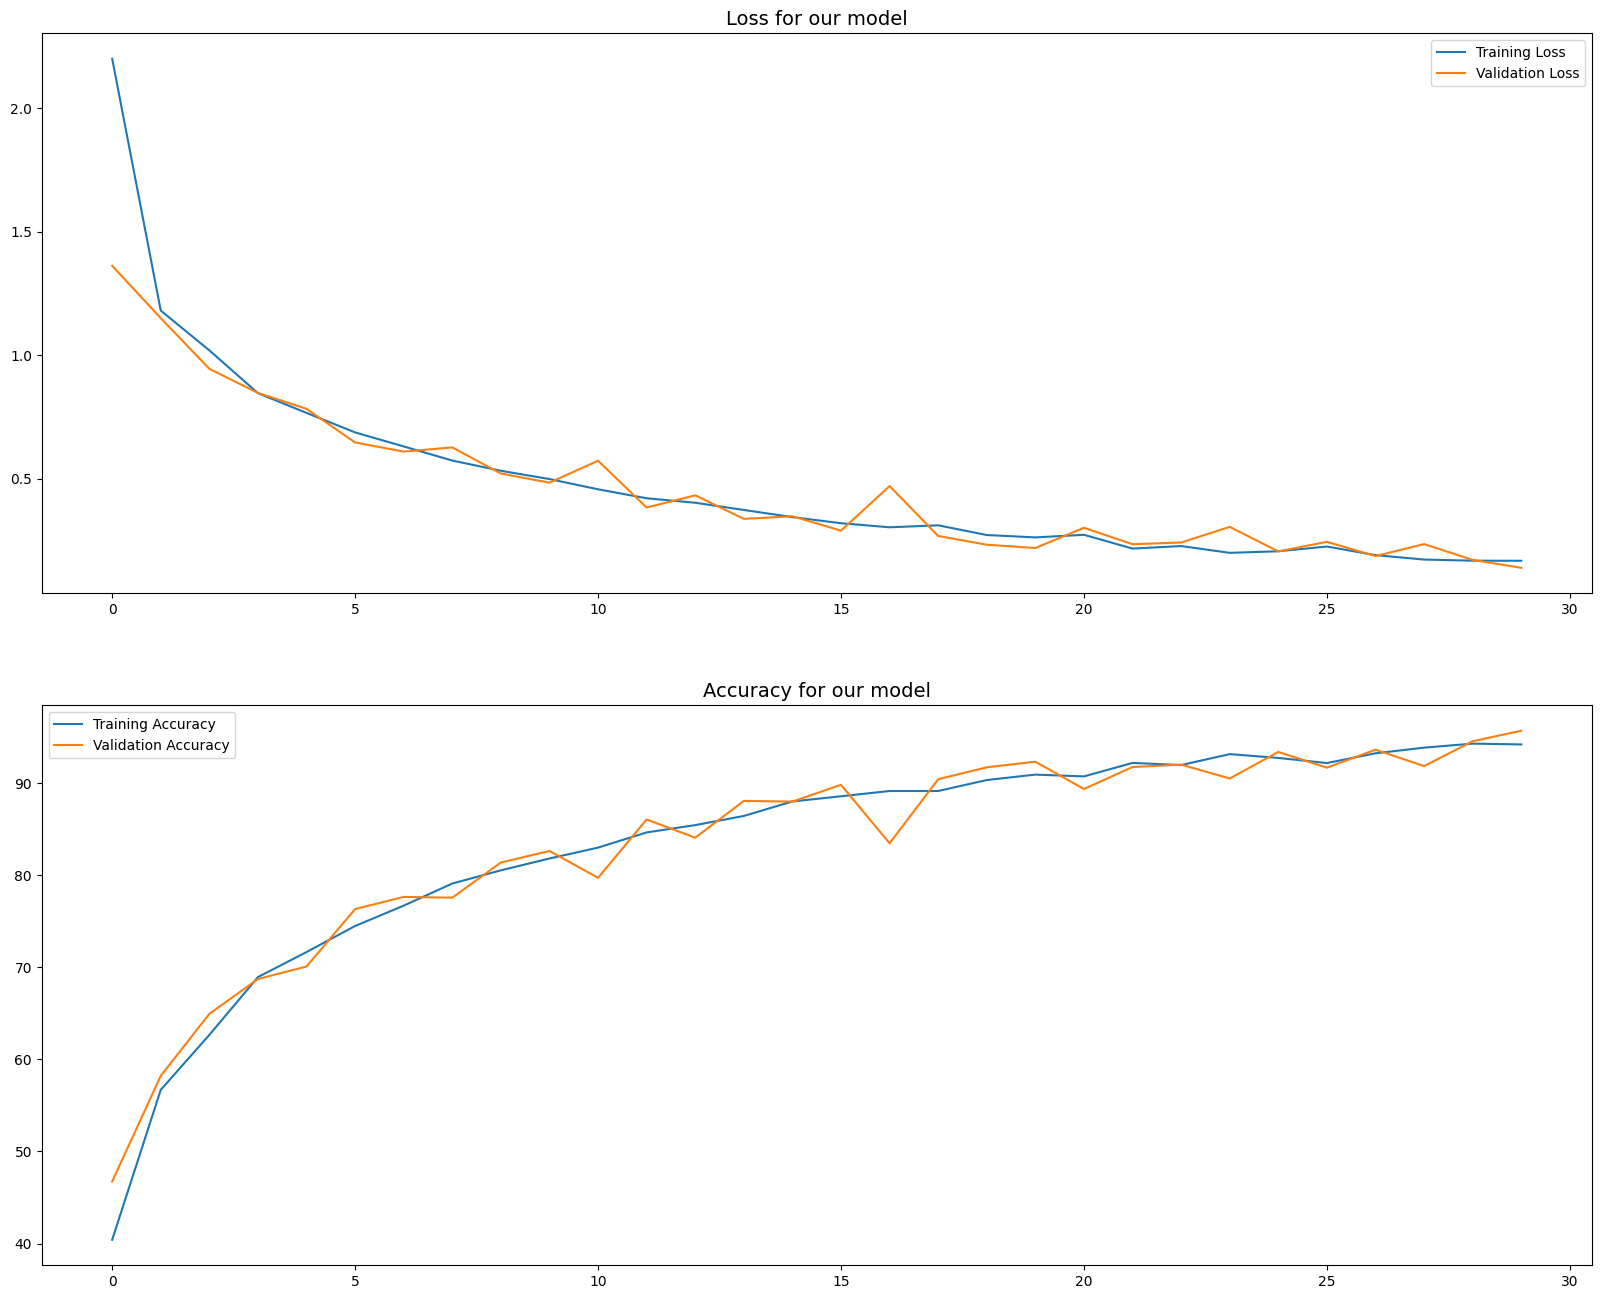

In [19]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss for our model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_title('Accuracy for our model', fontsize=14)  
fig2.legend()
plt.show()

In [17]:
# Load the best model state into the CNN model
best_model_state = torch.load('CNN_model.pth', map_location='cpu')
CNN_model.load_state_dict(best_model_state)

CNN_model.to('cpu')

device = torch.device('cpu')
test_accuracy = Model_functions.test_model(CNN_model, test_loader, device)

print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print('-------------------------------------------------------')


-------------------------------------------------------
Best model's accuracy: 95.6964892412231
-------------------------------------------------------


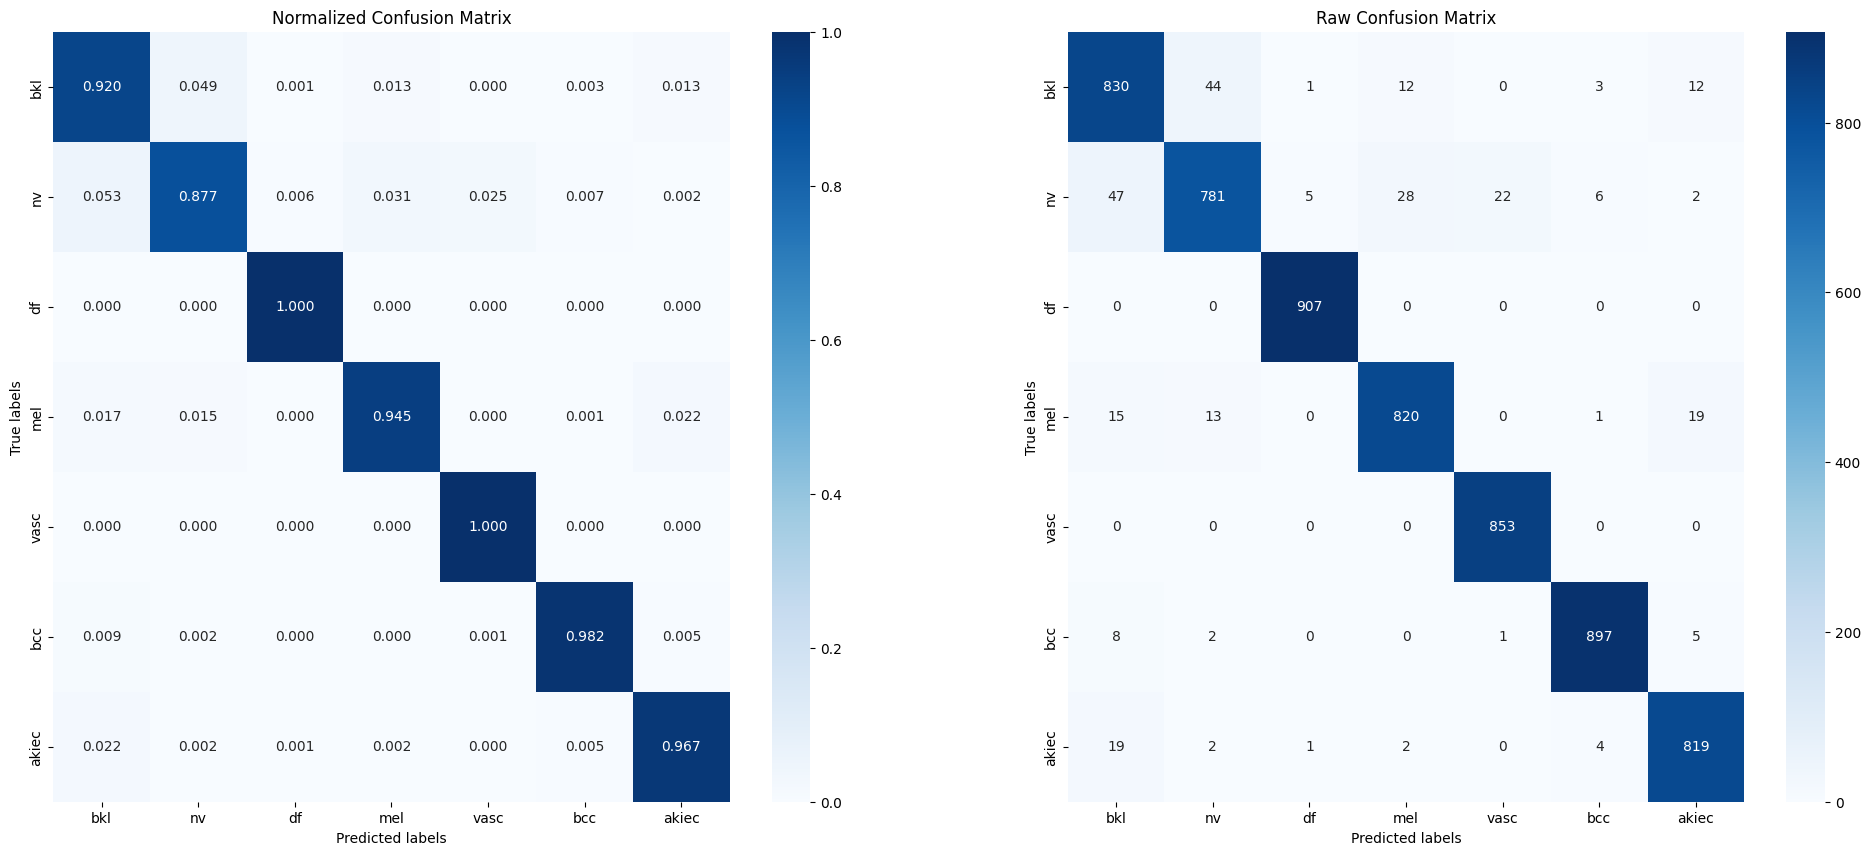

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.90      0.92      0.91       902
          nv       0.93      0.88      0.90       891
          df       0.99      1.00      1.00       907
         mel       0.95      0.94      0.95       868
        vasc       0.97      1.00      0.99       853
         bcc       0.98      0.98      0.98       913
       akiec       0.96      0.97      0.96       847

    accuracy                           0.96      6181
   macro avg       0.96      0.96      0.96      6181
weighted avg       0.96      0.96      0.96      6181

-------------------------------------------------------


In [18]:
Model_functions.conf_report(CNN_model, test_loader, 'CNN_from_scratch')